Logistic Regression ROC–AUC: 0.8416
XGBoost ROC–AUC: 0.8344


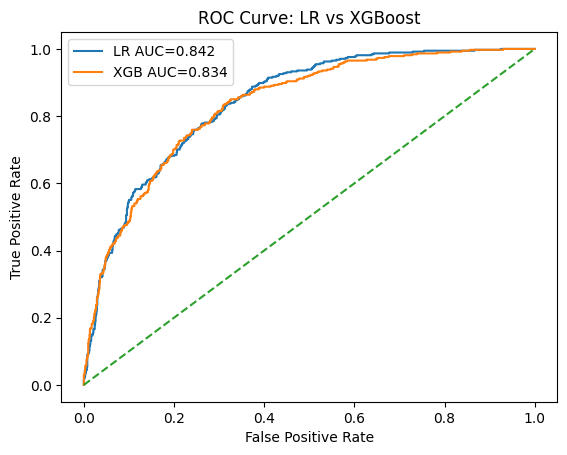


XGBoost CONFUSION MATRIX
[[688 347]
 [ 56 318]]

XGBoost CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9247    0.6647    0.7735      1035
           1     0.4782    0.8503    0.6121       374

    accuracy                         0.7140      1409
   macro avg     0.7015    0.7575    0.6928      1409
weighted avg     0.8062    0.7140    0.7306      1409


LogReg CONFUSION MATRIX (same threshold)
[[615 420]
 [ 35 339]]

LogReg CLASSIFICATION REPORT (same threshold)
              precision    recall  f1-score   support

           0     0.9462    0.5942    0.7300      1035
           1     0.4466    0.9064    0.5984       374

    accuracy                         0.6771      1409
   macro avg     0.6964    0.7503    0.6642      1409
weighted avg     0.8136    0.6771    0.6950      1409


Top 10 XGBoost feature importances:
Contract_Two year                     0.205080
InternetService_Fiber optic           0.183916
OnlineSecurity_No inter

In [7]:
# ============================================================
# CUSTOMER CHURN PREDICTION – LOGISTIC REGRESSION vs XGBOOST
# Run this in the same folder as your CustomerChurn.csv
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt

# -------------------------
# 1. LOAD & CLEAN
# -------------------------
df = pd.read_csv("CustomerChurn.csv")
df = df.drop(columns=["customerID"])
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"])

# -------------------------
# 2. TARGET + FEATURES
# -------------------------
y = (df["Churn"] == "Yes").astype(int)
df = df.drop(columns=["Churn"])

cat_cols = df.select_dtypes(include="object").columns
X = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Keep a copy of feature names
feature_columns = X.columns.tolist()

# -------------------------
# 3. SCALING numeric cols
#    (LR benefits; XGBoost fine either way)
# -------------------------
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# -------------------------
# 4. SPLIT: test and train (and val for early stopping)
# -------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# create small validation set from training for early stopping
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, stratify=y_train_full, random_state=42
)

# -------------------------
# 5. LOGISTIC REGRESSION (baseline)
# -------------------------
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear",
    random_state=42
)
log_reg.fit(X_train, y_train)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print("Logistic Regression ROC–AUC:", round(roc_auc_lr, 4))

# -------------------------
# 6. XGBOOST (version-safe)
# -------------------------

xgb = XGBClassifier(
    n_estimators=300,          # cap trees manually
    learning_rate=0.1,
    max_depth=4,               # control complexity
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    verbosity=0
)

xgb.fit(X_train_full, y_train_full)

y_prob_xgb = xgb.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print("XGBoost ROC–AUC:", round(roc_auc_xgb, 4))

# -------------------------
# 7. ROC CURVES (optional visual)
# -------------------------
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.plot(fpr_lr, tpr_lr, label=f"LR AUC={roc_auc_lr:.3f}")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB AUC={roc_auc_xgb:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: LR vs XGBoost")
plt.legend()
plt.show()

# -------------------------
# 8. THRESHOLD & METRICS (use same THRESHOLD as LR script)
# -------------------------
THRESHOLD = 0.35
y_pred_xgb = (y_prob_xgb >= THRESHOLD).astype(int)
print("\nXGBoost CONFUSION MATRIX")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nXGBoost CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_xgb, digits=4))

# show LR confusion for comparison at same threshold
y_pred_lr = (y_prob_lr >= THRESHOLD).astype(int)
print("\nLogReg CONFUSION MATRIX (same threshold)")
print(confusion_matrix(y_test, y_pred_lr))
print("\nLogReg CLASSIFICATION REPORT (same threshold)")
print(classification_report(y_test, y_pred_lr, digits=4))

# -------------------------
# 9. FEATURE IMPORTANCE (XGBoost)
# -------------------------
fi = pd.Series(xgb.feature_importances_, index=feature_columns).sort_values(ascending=False)
print("\nTop 10 XGBoost feature importances:")
print(fi.head(10))

# -------------------------
# 10. SAVE MODELS & ARTIFACTS
# -------------------------
joblib.dump(xgb, "churn_xgb_model.pkl")
joblib.dump(log_reg, "churn_logreg_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(feature_columns, "feature_columns.pkl")
print("\nModels and artifacts saved.")

# -------------------------
# 11.Comparision
# -------------------------
if roc_auc_xgb <= roc_auc_lr:
    print("\nroc_auc_xgb")
else:
    delta = roc_auc_xgb - roc_auc_lr
    print(f"\nXGBoost improved ROC–AUC by {delta:.4f} over Logistic Regression.")
